In [0]:
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [3]:
from IPython.display import SVG
# from graphviz import Source
# from python-graphviz import Source
from IPython.display import display

from IPython.display import HTML    
style = "<style>svg{width:10% !important;height:10% !important;}</style>"
HTML(style)

In [0]:
# увеличить размер графиков сиборн
sns.set(rc={'figure.figsize':(9,6)})

In [0]:
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')

In [6]:
# Ознакомимся с данными
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [7]:
# проверяем корректность данных
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [8]:
# преобразуем дату
events_data['date'] = pd.to_datetime(events_data.timestamp, unit = 's')
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit = 's')
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date
0,31971,1434349275,correct,15853,2015-06-15 06:21:15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49
3,31972,1478852164,correct,15853,2016-11-11 08:16:04
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03


In [9]:
# получим дни по полю дата
events_data['day'] = events_data.date.dt.date
submissions_data['day'] = submissions_data.date.dt.date
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


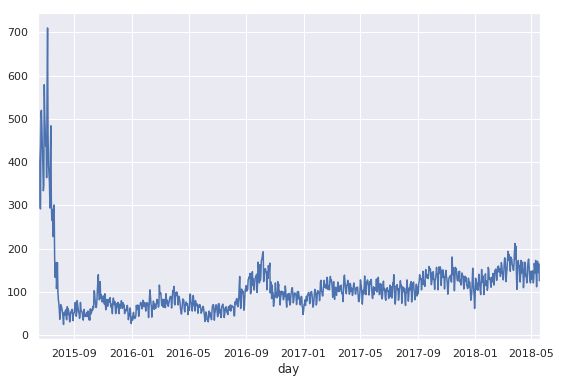

In [10]:
events_data.groupby('day').user_id.nunique().plot()

In [0]:
events_data.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index().head()
users_scores = submissions_data.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index().head()

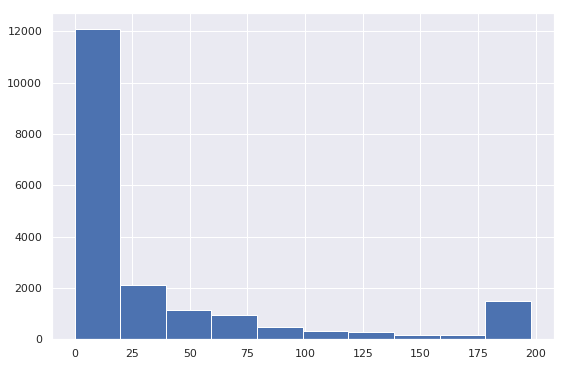

In [12]:
events_data.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index().discovered.hist()


In [0]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset = ['user_id', 'day'])\
.groupby('user_id')['timestamp']\
.apply(list)\
.apply(np.diff).values

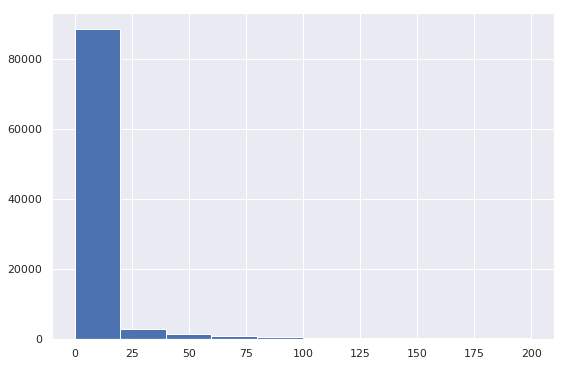

In [14]:
gap_data = pd.Series(np.concatenate(gap_data, axis = 0))
gap_data = gap_data / (24 * 60 * 60)
# gap_data.hist()
gap_data[gap_data < 200].hist()

In [15]:
30 * 24 * 60 * 60

2592000

In [16]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [0]:
users_data = events_data.groupby('user_id', as_index=False).agg({'timestamp':'max'}).rename(columns={'timestamp':'last_timestamp'})

In [0]:
# максимальная дата 
now = 1526772811
# подбираем по квантилям средний промежуток в учебе. Это 30 дней = 30 * 24 * 60 * 60
drop_out_threshold = 2592000

In [0]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold

In [20]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [0]:
users_data = users_data.merge(users_scores, how = 'outer')

In [0]:
users_data = users_data.fillna(0)

In [0]:
users_events_data = events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

In [0]:
users_data = users_data.merge(users_events_data, how = 'outer')

In [0]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [0]:
users_data = users_data.merge(users_days, how = 'outer')

In [27]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [28]:
# проверяем кол-во юзеров, вдруг потеряли

users_data.user_id.nunique()

19234

In [32]:
events_data.user_id.nunique()

19234

In [0]:
users_data['passed_course'] = users_data.passed > 170

In [31]:
events_data[events_data.action == 'passed'].pivot_table(index=['user_id'], 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index().sort_values('passed', ascending=False).head()

action,user_id,timestamp,passed
164477,6666,1471114338,5
241312,9880,1435308711,5
324289,13277,1488697682,5
196375,8063,1435311833,5
164474,6666,1471114335,5


In [39]:
# чтобы предположить пороговый срок, когда пользователь уйдет из курса, переберем разные даты
users_data[users_data.passed_course == True].day.median()

20.0

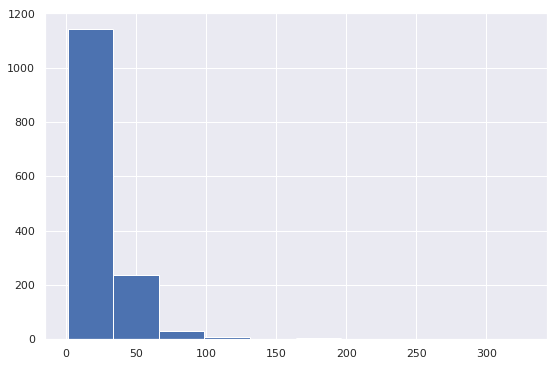

In [41]:
users_data[users_data.passed_course == True].day.hist()

In [43]:
user_min_time = events_data.groupby('user_id', as_index=False)\
.agg({'timestamp':'min'})\
.rename({'timestamp':'min_timestamp'}, axis=1)

user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [0]:
users_data = users_data.merge(user_min_time, how = 'outer')

In [48]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str) 
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [0]:
learning_time_threshold = 3 * 24 * 60 * 60

In [0]:
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_threshold).map(str)

In [54]:
user_learning_time_threshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

In [0]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

In [0]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how = 'outer')

In [57]:
# после каждой операции проверяем количество строк/столбцов/уникальных значение , зависит от функции присоединения
events_data.shape

(3480703, 8)

In [0]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]

In [60]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [0]:
submissions_data['users_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.users_time <= submissions_data.user_learning_time_threshold]
# submissions_data_train.groupby('user_id').day.nunique().max()

In [0]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index()\
.rename(columns={'day': 'days'})

In [0]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index()\
.rename(columns={'step_id': 'steps_tried'})

In [0]:
X = X.merge(steps_tried, on = 'user_id', how = 'outer')

In [0]:
X = X.merge(submissions_data_train.pivot_table(index=['user_id'], 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index())

In [0]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [0]:
X = X.merge(events_data_train.pivot_table(index=['user_id'], 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [0]:
X = X.fillna(0)

In [0]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how = 'outer')

In [0]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [0]:
y = X.passed_course.map(int)

In [0]:
X = X.drop(['passed_course', 'is_gone_user'], axis = 1)

In [0]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis = 1)

In [93]:
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132
